# Artificial Neural Network

In [1]:
%matplotlib inline

# The Problem

When we last left our agent in the `Value_Iteration` notebook, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it could see something like this:

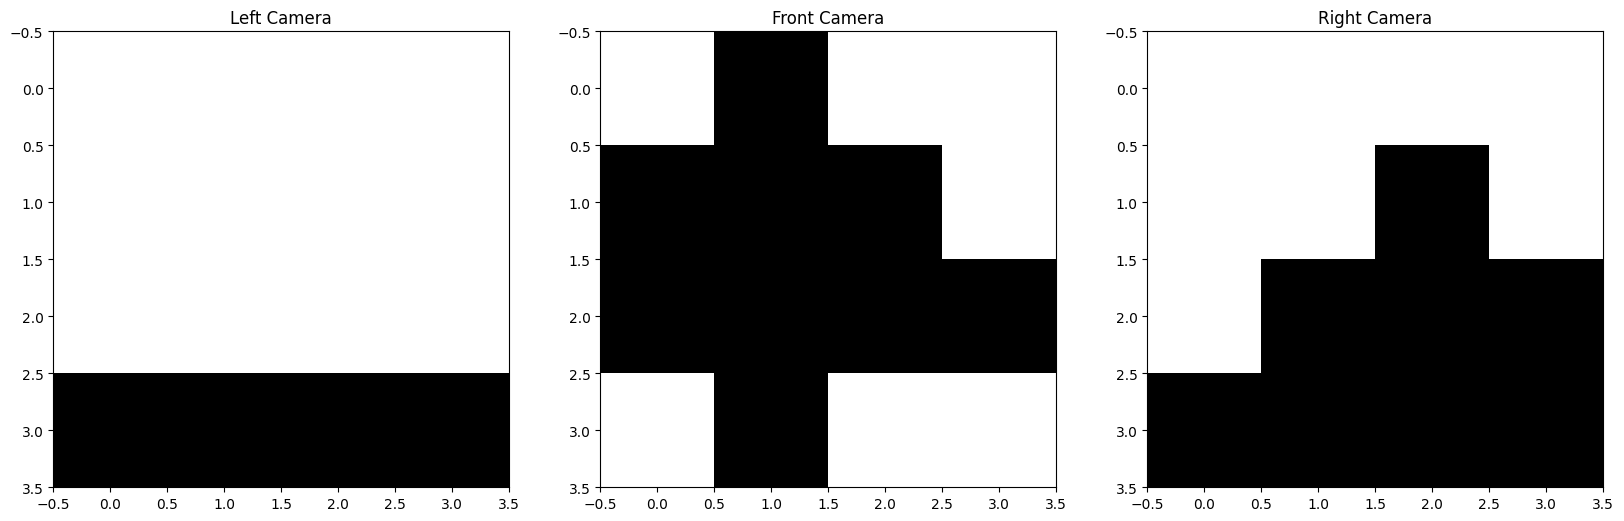

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.


The **goal of this notebook** is to **write an artificial neural network that determines what kind of terrain is nearby**. This is a multi-class problem.

## Data

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
# function by S. butcher, 2022
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

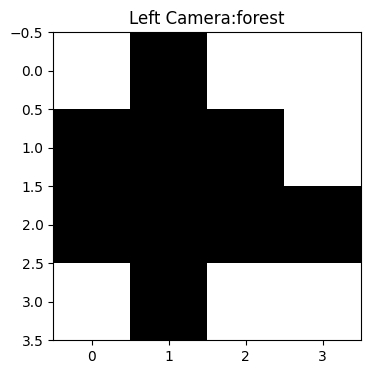

In [5]:
view_sensor_image( clean_data[ "forest"][0])

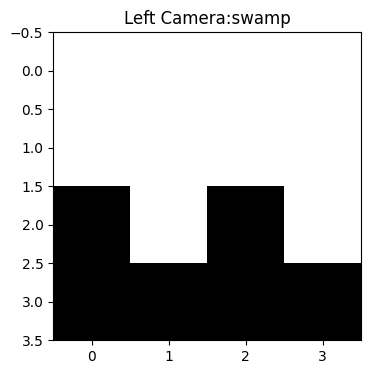

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
# function by S. Butcher, 2022
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

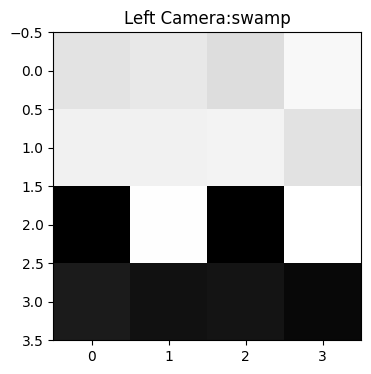

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

#### (Above code and descriptions by S. Butcher, 2022)

In [9]:
import random
import math
from typing import List, Tuple

encoding = {
        "hills": [1, 0, 0, 0],
        "swamp": [0, 1, 0, 0],
        "forest": [0, 0, 1, 0],
        "plains": [0,0, 0, 1]
    }

<a id="initialize_model"></a>
## initialize_model

*The initialize_model function takes the data, label_index, and number of hidden nodes as parameters. The model adds a bias term for each node as a column in the dataset. The function also initializes random weights for the hidden layer and output layer of the network. The function returns the updated data and initialized weights as a tuple of lists.* **Used by**: [learn_model](#learn_model)

* **data** List[List[float]]: the dataset containing randomly generated sensor data
* **label_index** int: the label index
* **hidden_nodes** int: the number of hidden nodes in the network

**returns** Tuple[List[List[float]]

In [10]:
def initialize_model(data: List[List[float]], label_index: int, hidden_nodes: int) -> Tuple[List[List[float]]]:
    # add a bias term as a column in the data to map to every hidden node
    new_data = np.array([row[:label_index] + row[label_index+1:] + [random.random()] for row in data])
    num_classes = len(set([tuple(row[label_index]) for row in data]))
    labels = np.array([row[label_index] for row in data])
    rows, cols = new_data.shape
    
    # initialize weights and add a bias term to each layer
    w_hidden = np.random.randn(cols, hidden_nodes+1)
    w_output = np.random.randn(hidden_nodes+1, num_classes)

    return new_data, w_hidden, w_output

In [11]:
# assertions/unit tests
test_data = [
    [0.12290786366213917, 0.13484888313872503, 0.12260104946519014, 0.10914496913043444, 
     0.09408764739969767, 0.07794693334680004, 0.0446566452953173, 0.13401008286363877, 
     0.09067805686912249, 0.09319845547775235, 0.0, 0.024009442213544258, 0.9269351933696378, 
     0.9779623369262631, 0.9591677551400427, 1.0, [0, 0, 1, 0]],
    [0.09597265540916722, 0.19918446323902844, 0.05364054506991042, 0.13000385177416085, 
     0.11414625022382346, 0.049594320318888954, 0.05214020267845927, 0.11495872963049501, 
     0.13285924596027635, 0.15516984199775058, 0.08408200429237883, 0.08834821858822176, 
     0.9146901020108895, 0.9773190742772409, 0.9133193864286313, 0.9171407355897104, [0, 0, 0, 1]]
]

new_data, test_weights_hidden, test_weights_output = initialize_model(test_data, len(test_data[0])-1, 2)

# assert bias term added as column
assert len(new_data[0]) == 17
# assert each row has 3 weights (2 classes and bias term)
assert len(test_weights_hidden[0]) == 3
# asserts 3 rows of weights to output layer, two hidden nodes and bias
assert len(test_weights_output) == 3
# asserts 2 cols of weights to output layer, for two hidden nodes
assert len(test_weights_output[0]) == 2

<a id="sigmoid"></a>
## sigmoid

*The sigmoid function applies the sigmoid activation function to the weighted summation calculated at each layer of a neural network on the forward pass.* **Used by**: [forward_propagation](#forward_propagation)

* **z** float: the weighted summation calculated for a layer in the neural network

**returns** float

In [12]:
def sigmoid(z: float) -> float:
    return 1 / (1 + np.exp(-z))

In [13]:
# assertions/unit tests
assert round(sigmoid(0.2081), 2) == 0.55
assert round(sigmoid(0.3418), 2) == 0.58
assert round(sigmoid(-0.06), 2) == 0.49

<a id="sigmoid_derivative"></a>
## sigmoid_derivative

*The sigmoid_derivative function calculates the derivative of the activation function. This value is used in the backpropagation step.* **Used by**: [backpropagation](#backpropagation)

* **z** float: the weighted error calculated for a layer in the neural network

**returns** float

In [14]:
def sigmoid_derivative(z: float) -> float:
    return z * (1 - z)

In [15]:
# assertions/unit tests
assert round(sigmoid_derivative(0.01), 2) == 0.01
assert round(sigmoid_derivative(0.9), 2) == 0.09
assert sigmoid_derivative(0.5) == 0.25

<a id="forward_propagation"></a>
## forward_propagation

*The forward_propagation function calculates the values of all nodes during the forward pass of the neural network using a sigmoid activation function. The function returns the updated nodes for the hidden and output layer of the network.* **Used by**: [learn_model](#learn_model), [apply_model](#apply_model)

* **data** List[List[float]]: the dataset containing randomly generated sensor data
* **w_hidden** List[List[float]]: the weights of the hidden layer
* **w_output** List[List[float]]: the weights of the output layer

**returns** Tuple[List[List[float]]]

In [16]:
def forward_propagation(data: List[List[float]], w_hidden: List[List[float]], w_output: List[List[float]]) -> Tuple[List[List[float]]]:
    z_hidden = np.dot(data, w_hidden)
    y_hidden = sigmoid(z_hidden)
    z_output = np.dot(y_hidden, w_output)
    y_output = sigmoid(z_output)
    return y_hidden, y_output

In [17]:
# tested in the main function

<a id="backpropagation"></a>
## backpropagation

*The backpropagation function updates the network weights by propagating the error back through the network.* **Used by**: [learn_model](#learn_model)

* **data** List[List[float]]: the dataset containing randomly generated sensor data
* **error** List[List[float]]: the error between the true labels and the predicted probabilities
* **y_hidden** List[List[float]]: the nodes of the hidden layer
* **y_output** List[List[float]]: the nodes of the output layer
* **w_hidden** List[List[float]]: the weights of the hidden layer
* **w_output** List[List[float]]: the weights of the output layer
* **alpha** float: the learning rate

**returns** Tuple[List[List[float]]]

In [18]:
def backpropagation(data: List[List[float]], error: List[List[float]], y_hidden: List[List[float]], y_output: List[List[float]], w_hidden: List[List[float]], w_output: List[List[float]], alpha: float) -> Tuple[List[List[float]]]:
    delta_o = error * sigmoid_derivative(y_output)
    # The dot product calculates the weighted error of the output layer
    delta_h = np.dot(delta_o, w_output.T) * sigmoid_derivative(y_hidden)
    # Update weights
    w_hidden += np.dot(data.T, delta_h) * alpha
    w_output += np.dot(y_hidden.T, delta_o) * alpha
    return w_hidden, w_output

In [19]:
# tested below in main function

<a id="get_error_rate"></a>
## get_error_rate

*The get_error_rate function returns the error rate of the results returned by the apply_model function.* **Used by**: [apply_model](#apply_model)

* **results** List[Tuple[float]]: the results returned by the apply_model function

**returns** float

In [20]:
def get_error_rate(results: List[Tuple[float]]) -> float:
    count_correct = 0
    for value in results:
        if (1, 1) in value:
            count_correct += 1
    return 1 - count_correct/len(results)

In [21]:
# assertions/unit tests
test_results_1 = [[(0,0), (1, 1)], [(0,0), (1, 1)]]

assert round(get_error_rate(test_results_1), 2) == 0.0

test_results_2 = [[(0,0), (1, 1)], [(0,1), (0, 0)]]

assert round(get_error_rate(test_results_2), 2) == 0.5

test_results_3 = [[(0,0), (0, 1)], [(0,1), (0, 0)]]

assert round(get_error_rate(test_results_3), 2) == 1.0

<a id="log_loss"></a>
## log_loss

*The log_loss function calculates the log loss (binary cross-entropy) between the predicted probabilities from a sigmoid activation function and the actual values.* **Used by**: [learn_model](#learn_model)

* **actual** List[List[int]]: the labels of the dataset (one-hot encoded)
* **predicted** List[List[float]]: the predicted probabilities
* **epsilon** float: a very small float to put values in the range of epsilon and 1-epsilon to prevent probabilities from reaching exactly 0 or 1.

**returns** float

In [22]:
def log_loss(actual: List[List[int]], predicted: List[List[float]], epsilon: float):
    # ensure that the probbailities do not go to exactly 0 or 1 by
    # getting the values in the range of epsilon and 1-epsilon
    predicted = np.clip(predicted, epsilon, 1 - epsilon)
    return -np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))

In [23]:
# assertions/unit tests
actual_test = np.array([[0, 0, 0, 1], [1, 0, 0, 0]])
predicted_test = np.array([[0.1, 0.1, 0.1, 0.7], [0.8, 0.2, 0.3, 0.1]])

assert round(log_loss(actual_test, predicted_test, 0.0001), 2) == 0.2

predicted_test_2 = np.array([[0.7, 0.1, 0.1, 0.1], [0.8, 0.2, 0.3, 0.1]])

assert round(log_loss(actual_test, predicted_test_2, 0.0001), 2) == 0.58

predicted_test_3 = np.array([[0.7, 0.1, 0.1, 0.1], [0.1, 0.5, 0.1, 0.1]])

assert round(log_loss(actual_test, predicted_test_3, 0.0001), 2) == 0.87

### generate_data

Generates an endless supply of blurred data from a collection of terrain prototypes.

* `data`: Dict[Str, List[Any]] - a Dictionary of "clean" prototypes for each landscape type.
* `n`: Int - the number of blurred examples of each terrain type to return.

returns

* List[List[Any]] - a List of Lists. Each individual List is a blurred example of a terrain type, generated from the prototype.

In [24]:
def generate_data(data, n, encoding):
    output_data = []
    for key, val in data.items():
        count = 0
        while count < n:
            # get a random class example and blur the data
            example = blur(random.choice(val))
            # change labels to one-hot encoding
            example.remove(key)
            example.append(encoding[key])
            output_data.append(example)
            count +=1
    random.shuffle(output_data)
    return output_data

Test out generate_data:

In [25]:
results = generate_data( clean_data, 2, encoding)
for result in results:
    print( result)

[0.10404721885797882, 0.12911358780885182, 0.15193016027958411, 0.09889416143842794, 0.07131309988649429, 0.1730180441586434, 0.029641413449977325, 0.029974128547931495, 0.13135759921573936, 0.9309003320649482, 0.0954534626773966, 0.8073173643296483, 1.0, 1.0, 1.0, 1.0, [0, 1, 0, 0]]
[0.11037399593711998, 0.1188699258464434, 0.10917773146868158, 0.0926759220262443, 0.1383726846833162, 0.06789708734622904, 0.13124167703830322, 0.031598019580500306, 0.16126497935668754, 0.062147666092414795, 0.12481330922364708, 0.03779048322331374, 0.9827828959623974, 0.8548725500366823, 0.7808657161289861, 0.9112034313561137, [0, 0, 0, 1]]
[0.08660894069912929, 0.04205438152369642, 0.09300024582286358, 0.05070541304059459, 0.09439519950690803, 0.7283103111217422, 0.054954187113258016, 0.17001535310068516, 0.8850388293518456, 0.8529913639739342, 0.8580976559568967, 0.08116778655936709, 0.9197727055441832, 0.9365358286615639, 1.0, 1.0, [1, 0, 0, 0]]
[0.06427805419659788, 0.024730512950287317, 0.828055127

<a id="learn_model"></a>
## learn_model

*The learn_model function implements an artificial neural network using a single hidden layer, a sigmoid activation function at the output layer, and log loss as the training evaluation metric. Alpha represents the learning rate for the model. The learning rate deteriorates if the training error increases between iterations.*

* **data** List[List[float]]: the sensor data
* **hidden_nodes** int: the number of nodes to use in the hidden layer
* **label_indexs** int: the label index
* **num_epochs** int: the algorithm will stop after this many iterations
* **alpha** float: the learning rate
* **epsilon** float: a very small float to put values in the range of epsilon and 1-epsilon in the log loss function to prevent probabilities from reaching exactly 0 or 1.
* **verbose** bool: specifies if the algorithm should print debug information about the training error and iterations
  
**returns** Tuple[List[List[float]]]

In [26]:
def learn_model(data: List[List[float]], hidden_nodes: int, label_index: int, num_epochs: int, alpha:float=0.01, epsilon:float=1e-04, verbose:bool=True) -> Tuple[List[List[float]]]:
    new_data, w_hidden, w_output = initialize_model(data, label_index, hidden_nodes)
    labels = np.array([row[label_index] for row in data])
    prev_loss = 100
    for current_iteration in range(num_epochs):
        # Forward propagation
        y_hidden, y_output = forward_propagation(new_data, w_hidden, w_output)

        # get the errors and loss for the current iteration
        error = labels - y_output
        loss = log_loss(labels, y_output, epsilon)
        if verbose and current_iteration % 1000 == 0:
            print(f"Iteration {current_iteration}, Loss: {loss}")
        
        # Backpropagation
        w_hidden, w_output = backpropagation(new_data, error, y_hidden, y_output, w_hidden, w_output, alpha)

        if loss > prev_loss:
            alpha = alpha / 10  
        prev_loss = loss
    return (w_hidden, w_output)

<a id="apply_model"></a>
## apply_model

*The apply_model function takes the ANN (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a List of Tuples of the inferred value (0 or 1) and the actual probability (something like (1, 0.73) or (0, 0.19) so you have [(0, 0.30), (1, 0.98), (0, 0.87), (0, 0.12)]. If the data is labeled, apply_model returns a List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1). Ex: for a single data point,[(0, 1), (0, 0), (0, 0), (1, 0)] is a misclassification, and [(0, 0), (0, 0), (1, 1), (0, 0)] will be a correct classification.*

* **model** Tuple[List[List[float]]]: the artificial neural network trained by the learn_model function
* **test_data** List[List[float]]: the sensor data for testing
* **labels** List[List[int]]: (optional) the test_data labels

  
**returns** List[Tuple[int|float]]

In [27]:
def apply_model( model: Tuple[List[List[float]]], test_data: List[List[float]], labels: List[List[int]]=[]) -> List[Tuple[int|float]]:
    w_hidden, w_output = model
    # Forward propagation
    y_hidden, y_output = forward_propagation(test_data, w_hidden, w_output)
    predictions = []
    if len(labels) == 0:
        for prediction in y_output:
            predicted = np.max(prediction)
            output = []
            for class_prob in predictions:
                output.append((0, class_prob)) if class_prob != np.max(prediction) else output.append((1, class_prob))
            predictions.append(output)
    else:
        for actual, prediction in zip(labels, y_output):
            predicted = np.max(prediction)
            output = []
            for actual_value, class_prob in zip(actual, prediction):
                output.append((actual_value, 1)) if class_prob == predicted else output.append((actual_value, 0))
            predictions.append(output)
    return predictions

Use `generate_data` to generate 100 blurred examples of each type (all four terrains).

In [28]:
train_data = generate_data( clean_data, 100, encoding)

Use `learn_model` to learn a ANN model for classifying sensor images as hills, swamps, plains or forest. **Set Verbose to True**

In [29]:
model = learn_model(train_data, 2, len(train_data[0])-1, 20000)

Iteration 0, Loss: 0.83021210324788
Iteration 1000, Loss: 0.1173047775078096
Iteration 2000, Loss: 0.05268280009658387
Iteration 3000, Loss: 0.036367818571334996
Iteration 4000, Loss: 0.030100925149892755
Iteration 5000, Loss: 0.026268082753909416
Iteration 6000, Loss: 0.023598266702414907
Iteration 7000, Loss: 0.0216001035864348
Iteration 8000, Loss: 0.020030470936734462
Iteration 9000, Loss: 0.018754797842425418
Iteration 10000, Loss: 0.017691364235334843
Iteration 11000, Loss: 0.016787187618212077
Iteration 12000, Loss: 0.01600614877268933
Iteration 13000, Loss: 0.015322679751058908
Iteration 14000, Loss: 0.014718070073455169
Iteration 15000, Loss: 0.014178283331823258
Iteration 16000, Loss: 0.013692513642314576
Iteration 17000, Loss: 0.013252320972970971
Iteration 18000, Loss: 0.012851021828279163
Iteration 19000, Loss: 0.012483217879797514


Use `generate_data` to generate 100 blurred examples of each terrain and use this as your test data.

In [30]:
test_data = generate_data( clean_data, 100, encoding)

Apply the model and evaluate the results.

In [31]:
# add column for bias 
new_data = np.array([row[:-1] + [random.random()] for row in test_data])
labels = np.array([row[-1] for row in test_data])

results = apply_model( model, new_data, labels)

print(f"Error rate: {get_error_rate(results)}")

Error rate: 0.0


The subsequent cells determine the optimal number of hidden nodes to use for this problem. 

In [32]:
def simple_evaluation(clean_data: List[List[float]], hidden_node_values:List[int]=[2, 4, 8]):
    train_data = generate_data( clean_data, 400, encoding)
    test_data = generate_data( clean_data, 100, encoding)
    
    train_with_bias = np.array([row[:-1] + [random.random()] for row in train_data])
    train_labels = np.array([row[-1] for row in train_data])
    test_with_bias = np.array([row[:-1] + [random.random()] for row in test_data])
    test_labels = np.array([row[-1] for row in test_data])
    
    for value in hidden_node_values:
        model = learn_model(train_data, value, len(train_data[0])-1, 15000, 0.01, 1e-04, False)
        train_results = apply_model( model, train_with_bias, train_labels)
        test_results = apply_model( model, test_with_bias, test_labels)
        train_error = get_error_rate(train_results)
        test_error = get_error_rate(test_results)
        print(f"Hidden Nodes: {value}, Train Error Rate: {train_error}, Test Error Rate: {test_error}") 

In [33]:
simple_evaluation(clean_data)

Hidden Nodes: 2, Train Error Rate: 0.0050000000000000044, Test Error Rate: 0.0050000000000000044
Hidden Nodes: 4, Train Error Rate: 0.0, Test Error Rate: 0.0
Hidden Nodes: 8, Train Error Rate: 0.0, Test Error Rate: 0.0


Four hidden nodes was the best choice for this problem. 